In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import numpy as np
from sklearn.metrics import confusion_matrix

In [5]:
import sys
sys.path.append('../')
from utils import engine

In [24]:
def calculate_pod_far(y_true, y_prob):
    # Initialize variables
    pods = []
    fars = []
    thresholds = np.arange(0, 1, 0.001)
    for i in thresholds:
        pred_classes = y_prob[:, None] >= i
        CR, FA, MISS, Hit = confusion_matrix(y_true, pred_classes).ravel()
        POD  = Hit/(Hit+MISS)
        F    = FA/(FA+CR)
        pods.append(POD)
        fars.append(F)

    return pods, fars


def multi_roc_curve(models_data, model_names,):
    fig, ax = plt.subplots(1, 1, figsize=(10,6))

    for data, name in zip(models_data, model_names):
        PODs, FARs = data
        roc_data = {"POD": PODs, "FAR": FARs}
        roc_df_logit = pd.DataFrame(roc_data).sort_values(by = ["POD", "FAR"])

        ROC_AUC = np.trapz(roc_df_logit["POD"], roc_df_logit["FAR"])

        POD_arr = np.array(roc_df_logit["POD"]) 
        FAR_arr = np.array(roc_df_logit["FAR"])


        FAR_cutoff = 0.1
        far_idx = np.where(np.array(roc_df_logit["FAR"]) > FAR_cutoff)[0].min()
        far_idx +=1

        pAUCc, pAUC, pAUCx, pAUCcn, pAUCn, pAUCxn, sPA = engine.concordant_partial_AUC(FAR_arr[:far_idx], 
                                                                                POD_arr[:far_idx])

        POD_cutoff = 0.7
        idx = np.where(POD_arr > POD_cutoff)[0].min()
        idx+=1
        PAI = auc(FAR_arr[idx:], POD_arr[idx:]) -  POD_arr[idx]*(1-FAR_arr[idx])
        PAI = PAI/(1-POD_arr[idx])

        ax.plot(roc_df_logit["FAR"], roc_df_logit["POD"], linewidth=3, label=f'{name} (AUC: {ROC_AUC:.2f} | pAUC: {pAUC:0.3f} | PAI: {PAI:0.2f})')
        ax.plot([0,1], [0,1],  linestyle='--', color='k')

    
    ax.grid()
    ax.legend(loc='lower right', fontsize=12)
    ax.set_xlim([-0.005, 1.0])
    ax.set_ylim([0.0, 1.005])
    ax.set_xlabel('Probability of false detection (FAR)',  fontsize=14)
    ax.set_ylabel('Probability of detection (POD)', fontsize=14)
    ax.set_title(f'ROC Curves Comparison')


In [19]:
fognet_test = pd.read_csv('/data1/fog/FogNet/trained_model/test_preds.csv')
PODs_f, FARs_f = calculate_pod_far(test_df_00.ytrue, fognet_test.pred_fog)

In [18]:
test_df_00 = pd.read_csv('/data1/fog/Hamid/SparkMET/EXPs/00_VVT_BCE_0001_01_30_32/test_prob_00_VVT_BCE_0001_01_30_32.csv', index_col= 0)
PODs_00, FARs_00 = calculate_pod_far(test_df_00.ytrue, test_df_00.fog_prob)

In [9]:
test_df_01 = pd.read_csv('/data1/fog/Hamid/SparkMET/EXPs/01_UVT_BCE_0001_01_20_32/test_prob_01_UVT_BCE_0001_01_20_32.csv', index_col= 0)
PODs_01, FARs_01 = calculate_pod_far(test_df_01.ytrue, test_df_01.fog_prob)

In [10]:
test_df_02 = pd.read_csv('/data1/fog/Hamid/SparkMET/EXPs/STT_V1_BCE_0001_01_30_256/test_prob_STT_V1_BCE_0001_01_30_256.csv', index_col= 0)
PODs_02, FARs_02 = calculate_pod_far(test_df_02.ytrue, test_df_02.fog_prob)

In [11]:
test_df_03 = pd.read_csv('/data1/fog/Hamid/SparkMET/EXPs/03_SVT_BCE_0001_01_20_128_init/test_prob_03_SVT_BCE_0001_01_20_128_init.csv', index_col= 0)
PODs_03, FARs_03 = calculate_pod_far(test_df_03.ytrue, test_df_03.fog_prob)

In [12]:
test_df_04 = pd.read_csv('/data1/fog/Hamid/SparkMET/EXPs/04_PIT_V1_BCE_0001_01_30_128/test_prob_04_PIT_V1_BCE_0001_01_30_128.csv', index_col= 0)
PODs_04, FARs_04 = calculate_pod_far(test_df_04.ytrue, test_df_04.fog_prob)

In [13]:
test_df_05 = pd.read_csv('/data1/fog/Hamid/SparkMET/EXPs/05_PIT_V2_BCE_0001_01_30_256/test_prob_05_PIT_V2_BCE_0001_01_30_256.csv', index_col= 0)
PODs_05, FARs_05 = calculate_pod_far(test_df_05.ytrue, test_df_05.fog_prob)

In [20]:
model_data_list = [(PODs_f, FARs_f), 
                   (PODs_00, FARs_00),
                   (PODs_01, FARs_01), 
                   (PODs_02, FARs_02), 
                   (PODs_03, FARs_03),
                   (PODs_04, FARs_04), 
                   (PODs_05, FARs_05),
                   ]


model_names_list = ["FogNet", "VVT", "UVT", "STT", "SVT", "PIT-V1", "PIT-V2"]

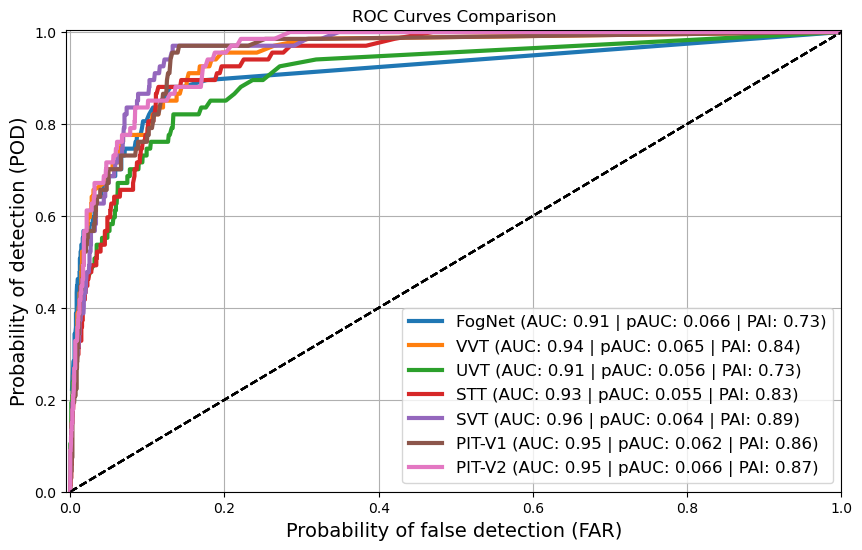

In [25]:
multi_roc_curve(model_data_list, model_names_list)